# 🌱 **Smart Farm: Geo-Storytelling,  Disease Classification and Yield Prediction**

This notebook explores a synthetic smart farming dataset to analyze and predict:
- 🗺️ Geographic storytelling and data visualization
- 🐛 Disease severity classification using supervised models
- 🌾 Crop yield based on environmental, operational and soil variables (regression and random forest)

The dataset simulates IoT and satellite data from 500 farms across regions like India, the US, and Africa, including information on weather, soil, and crop health.

---

📦 **Dataset source**:  
Available on Kaggle → [Smart Farming Crop Yield Dataset](https://www.kaggle.com/datasets/atharvasoundankar/smart-farming-sensor-data-for-yield-prediction/data)  
*(Login may be required)*

---



## 1. 📥 Data Loading

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import Normalize
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
import numpy as np


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error, r2_score

In [38]:
df = pd.read_csv("Smart_Farming_Crop_Yield_2024.csv") # Load the dataset from CSV (downloaded from Kaggle)

## 2. 📊  Exploratory Data Analysis

### Dataset overview

In [39]:
df.head()

,farm_id,region,crop_type,soil_moisture_%,soil_pH,temperature_C,rainfall_mm,humidity_%,sunlight_hours,irrigation_type,...,sowing_date,harvest_date,total_days,yield_kg_per_hectare,sensor_id,timestamp,latitude,longitude,NDVI_index,crop_disease_status
0,FARM0001,North India,Wheat,35.95,5.99,17.79,75.62,77.03,7.27,NaN,...,2024-01-08,2024-05-09,122,4408.07,SENS0001,2024-03-19,14.970941,82.997689,0.63,Mild
1,FARM0002,South USA,Soybean,19.74,7.24,30.18,89.91,61.13,5.67,Sprinkler,...,2024-02-04,2024-05-26,112,5389.98,SENS0002,2024-04-21,16.613022,70.869009,0.58,NaN
2,FARM0003,South USA,Wheat,29.32,7.16,27.37,265.43,68.87,8.23,Drip,...,2024-02-03,2024-06-26,144,2931.16,SENS0003,2024-02-28,19.503156,79.068206,0.80,Mild
3,FARM0004,Central USA,Maize,17.33,6.03,33.73,212.01,70.46,5.03,Sprinkler,...,2024-02-21,2024-07-04,134,4227.80,SENS0004,2024-05-14,31.071298,85.519998,0.44,NaN
4,FARM0005,Central USA,Cotton,19.37,5.92,33.86,269.09,55.73,7.93,NaN,...,2024-02-05,2024-05-20,105,4979.96,SENS0005,2024-04-13,16.568540,81.691720,0.84,Severe


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   farm_id               500 non-null    object 
 1   region                500 non-null    object 
 2   crop_type             500 non-null    object 
 3   soil_moisture_%       500 non-null    float64
 4   soil_pH               500 non-null    float64
 5   temperature_C         500 non-null    float64
 6   rainfall_mm           500 non-null    float64
 7   humidity_%            500 non-null    float64
 8   sunlight_hours        500 non-null    float64
 9   irrigation_type       350 non-null    object 
 10  fertilizer_type       500 non-null    object 
 11  pesticide_usage_ml    500 non-null    float64
 12  sowing_date           500 non-null    object 
 13  harvest_date          500 non-null    object 
 14  total_days            500 non-null    int64  
 15  yield_kg_per_hectare  5

### Missing values

In [41]:
print(df['irrigation_type'].unique())
print(df['crop_disease_status'].unique())

[nan 'Sprinkler' 'Drip' 'Manual']
['Mild' nan 'Severe' 'Moderate']


In [42]:
df["irrigation_type"] = df["irrigation_type"].fillna("No irrigation")
df["crop_disease_status"] = df["crop_disease_status"].fillna("No disease")

In [43]:
print(df['irrigation_type'].unique())
print(df['crop_disease_status'].unique())

['No irrigation' 'Sprinkler' 'Drip' 'Manual']
['Mild' 'No disease' 'Severe' 'Moderate']


In [44]:
df.isnull().sum()

farm_id                 0
region                  0
crop_type               0
soil_moisture_%         0
soil_pH                 0
temperature_C           0
rainfall_mm             0
humidity_%              0
sunlight_hours          0
irrigation_type         0
fertilizer_type         0
pesticide_usage_ml      0
sowing_date             0
harvest_date            0
total_days              0
yield_kg_per_hectare    0
sensor_id               0
timestamp               0
latitude                0
longitude               0
NDVI_index              0
crop_disease_status     0
dtype: int64

In [45]:
df['irrigation_type'] = df['irrigation_type'].replace([None, 'None'], 'No Irrigation')
df['crop_disease_status'] = df['crop_disease_status'].replace([None, 'None'], 'No disease')

### Transformation of dates

In [46]:
df['sowing_date'] = pd.to_datetime(df['sowing_date'])
df['harvest_date'] = pd.to_datetime(df['harvest_date'])
df['timestamp'] = pd.to_datetime(df['timestamp'])

### Categorical variables

In [47]:
# Have the rest of categorical variables only unique values?
categorical_columns = ['region', 'crop_type', 'fertilizer_type']

for i in categorical_columns:
    print(df[i].unique())

['North India' 'South USA' 'Central USA' 'East Africa' 'South India']
['Wheat' 'Soybean' 'Maize' 'Cotton' 'Rice']
['Organic' 'Inorganic' 'Mixed']


There are not duplicate values for categorical variables.

### Correlation analysis

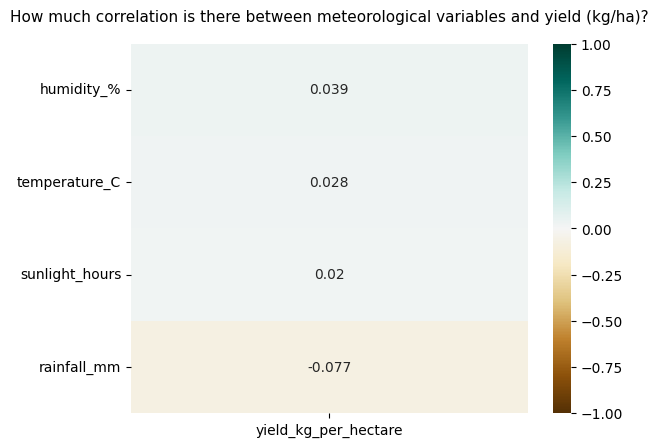

In [48]:
# 1. Correlation between metereological variables and yield
y_and_meteo_variables = df[['yield_kg_per_hectare', 'temperature_C', 'rainfall_mm', 'humidity_%', 'sunlight_hours']]
corr_values = y_and_meteo_variables.corr()[['yield_kg_per_hectare']].drop(index='yield_kg_per_hectare')

heatmap = sns.heatmap(corr_values.sort_values(by='yield_kg_per_hectare', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('How much correlation is there between meteorological variables and yield (kg/ha)?', fontdict={'fontsize':11}, pad = 16)

plt.show()

There is a very **low correlation** between **meteorological variables** and **yield in kg per hectare**.<br>  This low correlation is positive, except for precipitation, and therefore we can conclude that as humidity, temperature and average hours of sunlight increase, yield increases, while as precipitation increases, yield decreases.

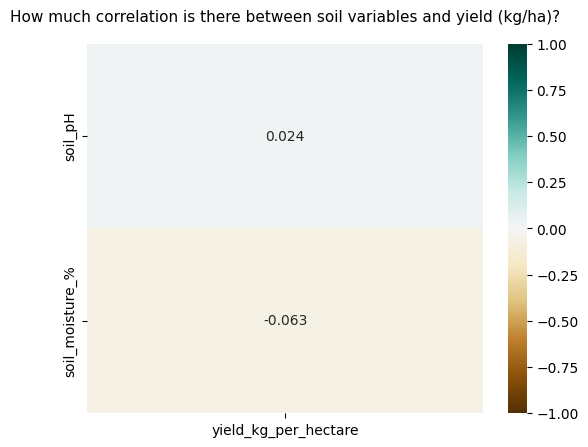

In [49]:
# 2. Correlation between soil variables and yield
y_and_soil_variables = df[['yield_kg_per_hectare', 'soil_moisture_%', 'soil_pH']]
corr_values = y_and_soil_variables.corr()[['yield_kg_per_hectare']].drop(index='yield_kg_per_hectare')

heatmap = sns.heatmap(corr_values.sort_values(by='yield_kg_per_hectare', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('How much correlation is there between soil variables and yield (kg/ha)?', fontdict={'fontsize':11}, pad = 16)

plt.show()

There is a very **low correlation** also between **soil variables** and **yield in kg per hectare**.<br>  This low correlation is positive with soil pH and therefore we can conclude that as pH increase, yield increases, while is a negative correlation between moisture and yield so as soil moisture increases, yield decreases.

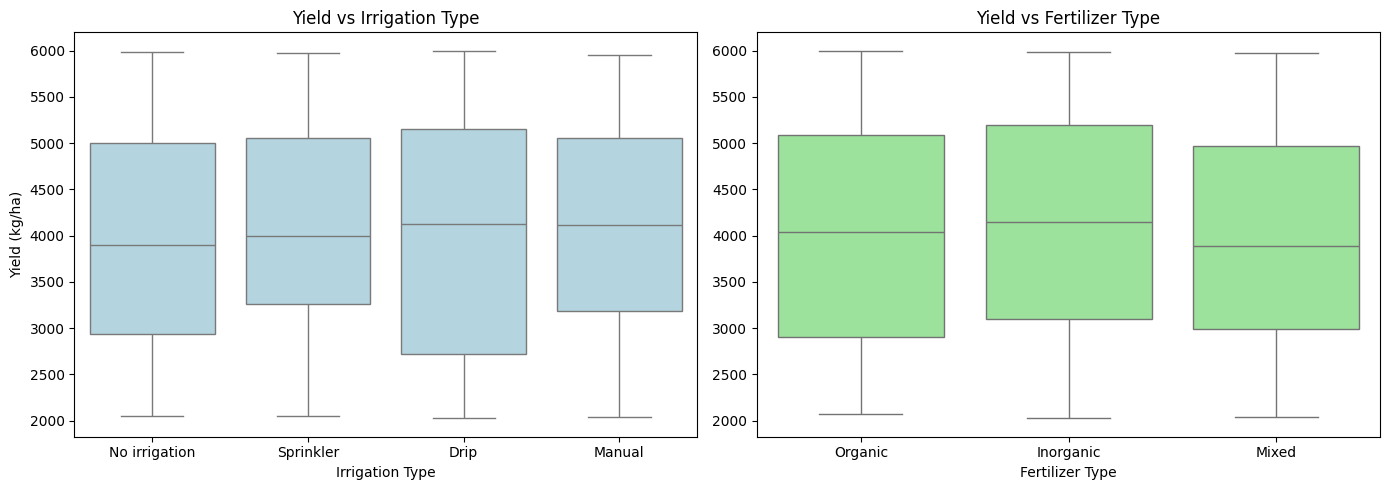

In [50]:
# 3. Correlation between operational variables and yield

# Irrigation type vs yield
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(x="irrigation_type", y="yield_kg_per_hectare", data=df, ax=axes[0], color='lightblue')
axes[0].set_title("Yield vs Irrigation Type")
axes[0].set_xlabel("Irrigation Type")
axes[0].set_ylabel("Yield (kg/ha)")

# Fertilizer type vs yield
sns.boxplot(x="fertilizer_type", y="yield_kg_per_hectare", data=df, ax=axes[1], color='lightgreen')
axes[1].set_title("Yield vs Fertilizer Type")
axes[1].set_xlabel("Fertilizer Type")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

Both <u>irrigation</u> and <u>fertilizer type</u> show **low correlation** with yield in this dataset, indicating that their influence is either minimal or overshadowed by other variables.

### Average yield for crop type

C:\Users\nucci\AppData\Local\Temp\ipykernel_21232\281206206.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


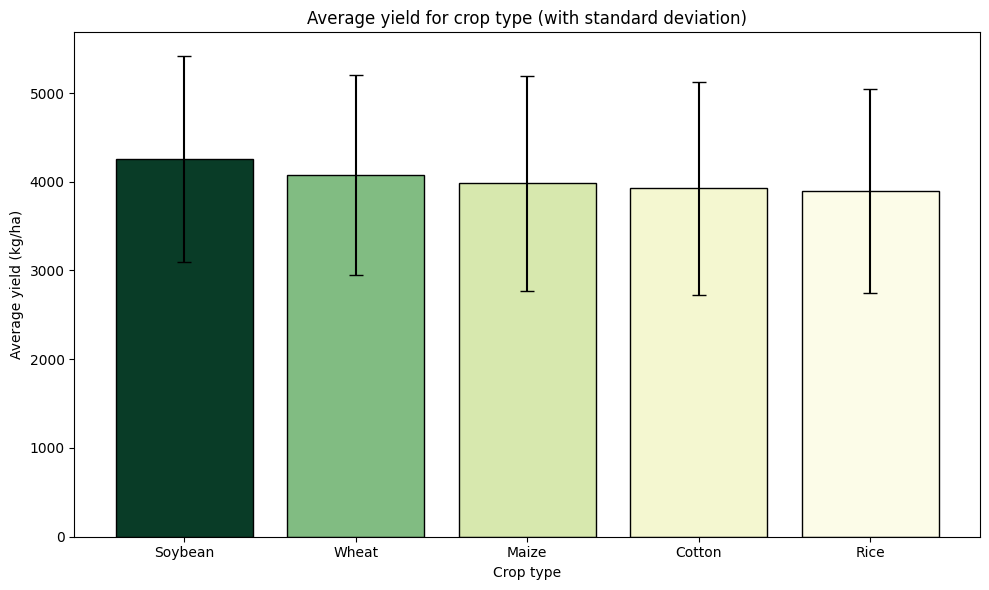

In [51]:
grouped = df.groupby("crop_type")["yield_kg_per_hectare"].agg(["mean", "std"]).reset_index()
grouped = grouped.sort_values(by='mean', ascending=False).reset_index(drop=True)

cmap = plt.cm.YlGn

norm = plt.Normalize(vmin=grouped['mean'].min(), vmax=grouped['mean'].max()) # normalization to have: low values → lighter color, higher values → darker color
colors_graph = [cmap(norm(value)) for value in grouped['mean']]  

plt.figure(figsize=(10, 6))

barplot = sns.barplot(
    data=grouped,
    x='crop_type',
    y='mean',
    palette=colors_graph,
    edgecolor='black'
)

for i, (mean, std) in enumerate(zip(grouped['mean'], grouped['std'])):
    plt.errorbar(
        x=i,
        y=mean,
        yerr=std,
        fmt='none',
        ecolor='black',
        capsize=5,
        linewidth=1.5
    )

plt.title("Average yield for crop type (with standard deviation)")
plt.xlabel("Crop type")
plt.ylabel("Average yield (kg/ha)")
plt.xticks(ticks=range(len(grouped)), labels=grouped['crop_type'])
plt.tight_layout()
plt.show()

The crop type that has an <u>higher</u> average yield is **Soybean**, while **Rice** is characterized by the <u>lowest</u> average yield.<br> But the differences **don't appear to be significant**.

### Distribution of Yield

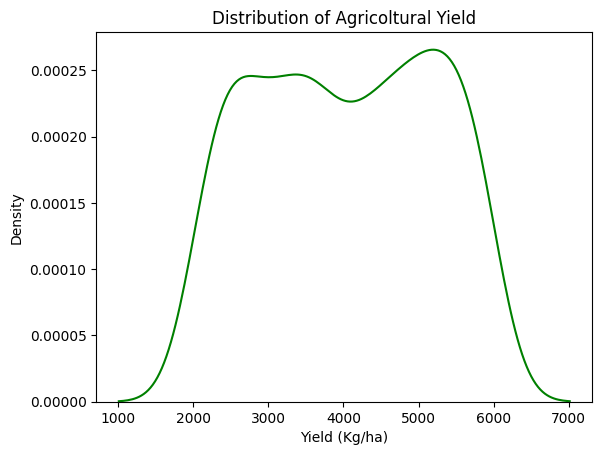

In [52]:
sns.kdeplot(x = df['yield_kg_per_hectare'], color='green')
plt.title('Distribution of Agricoltural Yield')
plt.xlabel('Yield (Kg/ha)')
plt.show()

The graph shows a **bimodal distribution** of agricultural yield, with <u>two main peaks</u> located between 2500-3500 kg/ha and 5000-6000 kg/ha respectively. This suggests the presence of <u>two distinct subgroups within the dataset</u>, potentially linked to different production methods or *environmental conditions*. <br>Extreme values ​​(under 1500 or over 6500 kg/ha) are rare.

## 3. 🎯 Project Objectives

#### **Objective 1 -  🗺️ Geo-Storytelling**

In this section follows a mapping of how <u>yield</u> , <u>moisture</u>,  <u>crop health</u> and <u>NVDI</u> change based on geographical location.<br><br> There are 4 maps:
1) Map for crop yield
2) Map for moisture
3) Map for crop health status
4) Map for NVDI

In [53]:
# Map with the starting position centred in the mean of all coordinates
map_center = [df["latitude"].mean(), df["longitude"].mean()] 

🌾 ***1. Crop yield (kg/ha)***<br><br> More green = more productivity


In [ ]:
# === 1. MAP FOR YIELD ===
yield_map = folium.Map(location=map_center, zoom_start=6)
yield_cluster = MarkerCluster().add_to(yield_map) # To group markers when they are close together

norm_yield = Normalize(vmin=df["yield_kg_per_hectare"].min(), vmax=df["yield_kg_per_hectare"].max())
cmap_yield = cm.get_cmap('YlGn')

for _, row in df.iterrows():
    color = colors.to_hex(cmap_yield(norm_yield(row['yield_kg_per_hectare'])))
    popup = (
        f"Farm ID: {row['farm_id']}<br>"
        f"Crop: {row['crop_type']}<br>"
        f"Yield: {row['yield_kg_per_hectare']} kg/ha<br>"
        )
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=5, fill=True, fill_color=color, color=color, fill_opacity=0.7, popup=popup
    ).add_to(yield_cluster)

# yield_map

In [56]:
yield_map.save("yield_map.html")

📍 [Click here to view the interactive map](https://cnucc.github.io/smart-farming/yield_map.html)



In [20]:
# Control of some farms that are represented in the sea
#df[df['farm_id'] == 'FARM0288']
#df[df['farm_id'] == 'FARM0375']
#df[df['farm_id'] == 'FARM0358']

# According to google maps coordinate gps of these farms are corrected and they appear in the sea.

💧 ***2. Moisture (%)***<br><br> More blu = more moisture

In [ ]:
# === 2. MAP FOR HUMIDITY ===
humidity_map = folium.Map(location=map_center, zoom_start=6)
humidity_cluster = MarkerCluster().add_to(humidity_map)

norm_hum = colors.Normalize(vmin=df["humidity_%"].min(), vmax=df["humidity_%"].max())
cmap_hum = cm.get_cmap('Blues')

for _, row in df.iterrows():
    color = colors.to_hex(cmap_hum(norm_hum(row['humidity_%'])))
    popup = (
        f"Farm ID: {row['farm_id']}<br>"
        f"Crop: {row['crop_type']}<br>"
        f"Humidity: {row['humidity_%']}%<br>Farm ID: {row['farm_id']}"
    )
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=5, fill=True, fill_color=color, color=color, fill_opacity=0.7, popup=popup
    ).add_to(humidity_cluster)

# humidity_map

In [57]:
humidity_map.save("humidity_map.html")

📍 [Click here to view the interactive map](https://cnucc.github.io/smart-farming/humidity_map.html)

🐛 ***3. Crop health status***<br><br>🟢 No disease 🟡 Mild 🟠 Moderate 🔴 Severe

In [ ]:
# === 3. MAP FOR CROP STATUS ===
disease_map = folium.Map(location=map_center, zoom_start=6)
disease_cluster = MarkerCluster().add_to(disease_map)

disease_colors = {
    "No disease": "green",
    "Mild": "yellow",
    "Moderate": "orange",
    "Severe": "red"
}

for _, row in df.iterrows():
    color = disease_colors.get(row['crop_disease_status'], "gray")
    popup = (
        f"Farm ID: {row['farm_id']}<br>"
        f"Crop: {row['crop_type']}<br>"
        f"Disease: {row['crop_disease_status']}<br>Farm ID: {row['farm_id']}"
    )
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=5, fill=True, fill_color=color, color=color, fill_opacity=0.7, popup=popup
    ).add_to(disease_cluster)

# disease_map

In [58]:
disease_map.save("disease_map.html")

📍 [Click here to view the interactive map](https://cnucc.github.io/smart-farming/disease_map.html)

**🌿 4. *Normalized Difference Vegetation Index***

Because NVDI index is a recognized indicator to measure:<br>
the correlation with **yield**,<br>
the **vegetative health** of crops,<br>
and the photosynthetic activity,<br>
in this map there is a representation of NVDI index for the 500 farms in the dataset.

NDVI values range from -1 to +1.
- Values close to +1 : very dense and healthy vegetation;
- Values between 0.2 and 0.5: less dense or stressed vegetation;
- Values close to 0: almost absent canopy cover;
- Negative values (<0): bare soil.

In this dataset the range is from *0.3* to *0.9* and the specific interpetation is:

- 0.3 |- 0.4 → Low canopy cover, low vigour or very low canopy cover, high vigour
- 0.4 |- 0.5 → Mid-low canopy cover, low vigour or low canopy cover, high vigour
- 0.5 |– 0.6	→ Average canopy cover, low vigour or mid-low canopy cover, high vigour
- 0.6 |– 0.7	→ Mid-high canopy cover, low vigour or average canopy cover, high vigour
- 0.7 |– 0.8	→ High canopy cover, high vigour
- 0.8 |–| 0.9	→ Very high canopy cover, very high vigour

In [23]:
map_center = [df["latitude"].mean(), df["longitude"].mean()]
farm_map = folium.Map(location=map_center, zoom_start=6)

marker_cluster = MarkerCluster().add_to(farm_map)

bin_to_color = {
    0: '#a50026',  # 0.30–0.39
    1: '#f46d43',  # 0.40–0.49
    2: '#fee08b',  # 0.50–0.59
    3: '#d9ef8b',  # 0.60–0.69
    4: '#66bd63',  # 0.70–0.79
    5: '#006837',  # 0.80–0.90
}

bins = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
labels = [0, 1, 2, 3, 4, 5]
df['ndvi_bin'] = pd.cut(df['NDVI_index'], bins=bins, labels=labels, include_lowest=True)

for _, row in df.iterrows():
    bin_label = row['ndvi_bin']
    if pd.isna(bin_label):
        continue
    color = bin_to_color[int(bin_label)]
    
    popup_text = (
        f"Farm ID: {row['farm_id']}<br>"
        f"Crop: {row['crop_type']}<br>"
        f"NDVI index: {row['NDVI_index']:.2f}"
    )
    
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=5,
        fill=True,
        color=None,
        fill_color=color,
        fill_opacity=0.6,
        popup=popup_text,
    ).add_to(marker_cluster)

legend_html = '''
<div style="
    position: fixed; 
    upper: 50px; left: 50px; width: 170px; height: 170px; 
    background-color: white; 
    border:2px solid grey; 
    z-index:9999; 
    font-size:14px;
    padding: 10px;
">
    <b>NDVI Index Range</b><br>
    <i style="background:#a50026; width:10px; height:10px; float:left; margin-right:5px"></i> 0.30–0.39<br>
    <i style="background:#f46d43; width:10px; height:10px; float:left; margin-right:5px"></i> 0.40–0.49<br>
    <i style="background:#fee08b; width:10px; height:10px; float:left; margin-right:5px"></i> 0.50–0.59<br>
    <i style="background:#d9ef8b; width:10px; height:10px; float:left; margin-right:5px"></i> 0.60–0.69<br>
    <i style="background:#66bd63; width:10px; height:10px; float:left; margin-right:5px"></i> 0.70–0.79<br>
    <i style="background:#006837; width:10px; height:10px; float:left; margin-right:5px"></i> 0.80–0.90
</div>
'''

farm_map.get_root().html.add_child(folium.Element(legend_html))

farm_map

4.1 **Average yield** for different NDVI values

In [24]:
# Average Yield for every bin
mean_yield_by_ndvi = df.groupby('ndvi_bin')['yield_kg_per_hectare'].mean().round(2)

ndvi_label_mapping = {
    0: "0.30–0.39",
    1: "0.40–0.49",
    2: "0.50–0.59",
    3: "0.60–0.69",
    4: "0.70–0.79",
    5: "0.80–0.90",
}

mean_yield_by_ndvi.index = mean_yield_by_ndvi.index.map(ndvi_label_mapping)
mean_yield_by_ndvi


C:\Users\nucci\AppData\Local\Temp\ipykernel_21232\1187076266.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_yield_by_ndvi = df.groupby('ndvi_bin')['yield_kg_per_hectare'].mean().round(2)


ndvi_bin
0.30–0.39    3862.99
0.40–0.49    4180.22
0.50–0.59    4043.27
0.60–0.69    4075.86
0.70–0.79    3950.66
0.80–0.90    4147.54
Name: yield_kg_per_hectare, dtype: float64

The lowest values of NVDI (0.30 - 0.39) have the lowest average yield (3862.99 kg/ha).<br>
Farms with an NDVI between 0.40 and 0.49 have the highest average yield (4180.22 kg/ha), so contrary to what one might expect **crop yield does not increase linearly with increasing NDVI**. This could indicate that an NDVI that is “too high” does not always coincide with maximum yield, perhaps due to other factors such as humidity or environmental stress.<br>**So probably the only NDVI is not sufficient to explain the productivity.**

4.2 Percentage of **disease** for different NDVI values

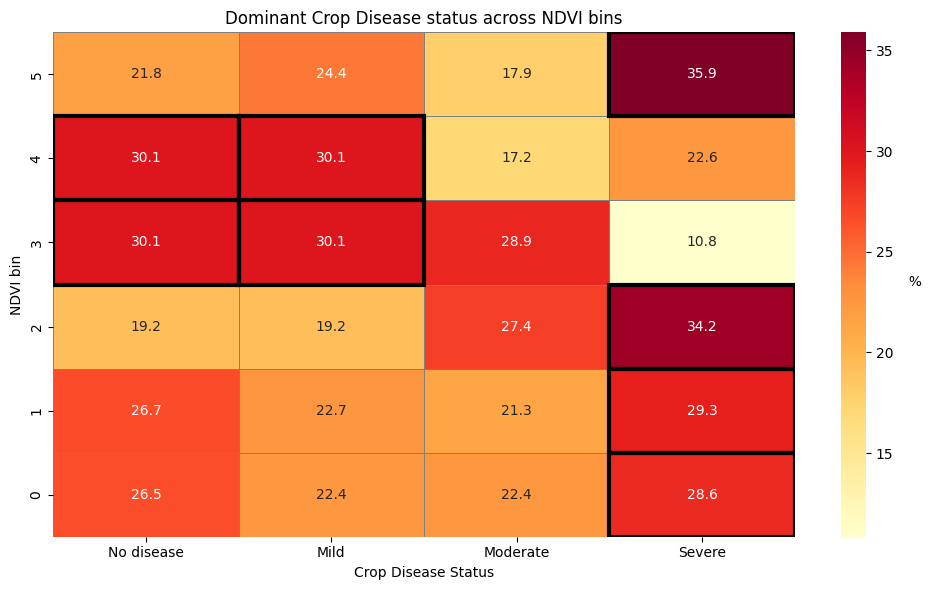

In [25]:
desired_order = ["No disease", "Mild", "Moderate", "Severe"]
heatmap_data = pd.crosstab(df['ndvi_bin'], df['crop_disease_status'])
heatmap_data = heatmap_data.reindex(columns=desired_order)
heatmap_percent = heatmap_data.div(heatmap_data.sum(axis=1), axis=0) * 100

# Max values for each columns
max_positions = heatmap_percent.eq(heatmap_percent.max(axis=1), axis=0)

plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    heatmap_percent,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    cbar_kws={'label': '%'},
    linewidths=0.5,
    linecolor='gray'
)

colorbar = ax.collections[0].colorbar
colorbar.set_label('%', rotation=180, labelpad=15)

# To highlight max values for each bin value
for y in range(max_positions.shape[0]):
    for x in range(max_positions.shape[1]):
        if max_positions.iloc[y, x]:
            ax.add_patch(plt.Rectangle((x, y), 1, 1, fill=False, edgecolor='black', lw=3))

plt.title("Dominant Crop Disease status across NDVI bins")
plt.xlabel("Crop Disease Status")
plt.ylabel("NDVI bin")
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()

In [26]:
df['ndvi_bin'].value_counts() # control of number of observations for each NDVI bin to evaluate if the data are unbalanced

ndvi_bin
0    98
4    93
3    83
5    78
1    75
2    73
Name: count, dtype: int64

The graph shows that while <u>lower NDVI bins are generally associated with higher disease severity</u>, *bin 5 (highest NDVI i.e. 0.80 - 0.90) also exhibits the highest proportion of severe disease cases (35.9%)*. The sample size (n=78) is comparable to other bins, this confirms that the data are not unbalanced but instead that **high NDVI values alone are not always reliable indicators of plant health**. Some diseases may not immediately impact NDVI values, leading some hidden problems such as internal diseases, plant root problems, etc.

#### **Objective 2 -  🐛  Disease Classification**

In this section there is an application of some **supervised ML model** to <u>predict crop health</u> (*crop_disease_status*) based on environmental conditions, soil and operational variables.<br><br> 

🔹 **Weather variables**<br>
*temperature_C*<br>
*rainfall_mm*<br>
*humidity_*%<br>
*sunlight_hours*<br>
🔹**Soil variables**<br>
*soil_moisture_%*<br>
*soil_pH*<br>
🔹 **Operational variable**s<br>
*NDVI_index*<br>
*irrigation_type*<br>
*fertilizer_type*<br>
<br><br>The structure of this section is organized in this way: <br>1. Preprocessing<br> 2. Models construction<br> 3. Interpretation of the models

 ***1. Preprocessing***


In [27]:
df['crop_disease_status'].value_counts() # there is not class imbalance

crop_disease_status
Severe        133
No disease    130
Mild          125
Moderate      112
Name: count, dtype: int64

In [28]:
# Environmental, soil variables and operating practices as features
features = ['temperature_C', 'rainfall_mm', 'humidity_%','sunlight_hours', 'soil_moisture_%', 'soil_pH', 'irrigation_type', 'fertilizer_type','NDVI_index' ]
X = df[features]

The variable *pesticide_usage_ml* is not included as a feature of the predictive model because it represents a management action following a disease and not a pre-existing environmental or operational condition.

In [29]:
# One-Hot Encoding of irrigation_type and fertilizer_type
X = pd.get_dummies(X, columns=['irrigation_type', 'fertilizer_type'])

In [30]:
# Target variable
disease_order = {'No disease': 0, 'Mild':1, 'Moderate':2, 'Severe':3} 
y = df['crop_disease_status'].map(disease_order)

In [31]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400, 14), (100, 14), (400,), (100,))

 ***2. Models construction***

##### Random forest

In [32]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [33]:
def evaluate_classifier(y_true, y_pred):
    return {
        "Accuracy": round(accuracy_score(y_true, y_pred), 2),
        "F1 Score (macro)": round(f1_score(y_true, y_pred, average="macro"), 2),
        "Confusion Matrix": confusion_matrix(y_true, y_pred)
    }

rf_results = evaluate_classifier(y_test, y_pred_rf)
print("Random Forest:", rf_results)

Random Forest: {'Accuracy': 0.19, 'F1 Score (macro)': 0.17, 'Confusion Matrix': array([[ 7, 10,  4,  5],
       [ 7,  6,  3,  9],
       [ 3, 12,  0,  7],
       [11,  4,  6,  6]])}


Feature importance

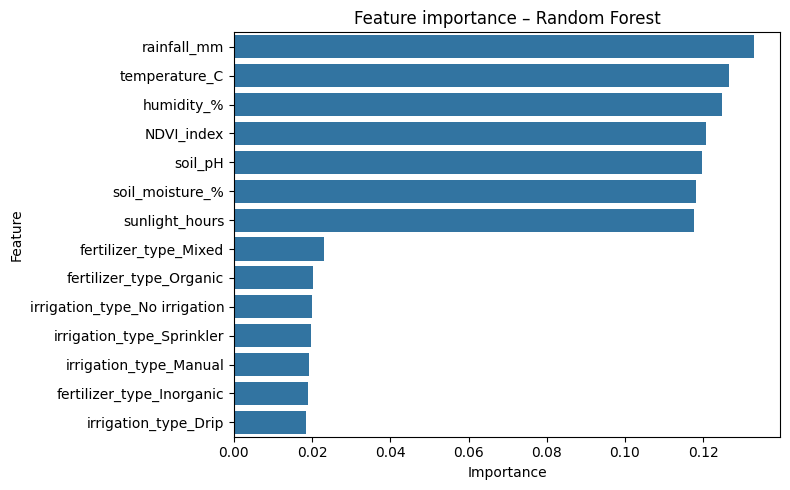

In [34]:
importances = rf_model.feature_importances_
feature_names = X.columns
feat_imp = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feat_imp = feat_imp.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x="Importance", y="Feature", data=feat_imp)
plt.title("Feature importance – Random Forest")
plt.tight_layout()
plt.show()

- Rainfall, temperature, and humidity stood out as the top contributors, highlighting the strong influence of climatic conditions on crop productivity.

- Features like NDVI index, soil pH, and soil moisture also played an important role, suggesting that crop health and soil properties contribute meaningfully to yield variation.

- In contrast, operational variables such as irrigation and fertilizer type had limited impact, possibly reflecting their lower variability or indirect influence in this dataset.

<br>
Despite identifying relevant drivers, the model’s overall performance was modest — pointing to the need for additional, more detailed agronomic data to improve prediction accuracy.



##### XGBoost

In [35]:
xgb_model = XGBClassifier(random_state=42, use_label_encoder = False, eval_metric = 'mlogloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

C:\Users\nucci\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\xgboost\training.py:183: UserWarning: [10:57:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [70]:
xgb_results = evaluate_classifier(y_test, y_pred_xgb)
print("XGBoost:", xgb_results)

XGBoost: {'Accuracy': 0.27, 'F1 Score (macro)': 0.27, 'Confusion Matrix': array([[ 8,  9,  1,  8],
       [ 3,  6,  7,  9],
       [ 2,  7,  5,  8],
       [10,  3,  6,  8]])}


##### SVM

In [36]:
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

In [72]:
svm_results = evaluate_classifier(y_test, y_pred_svm)
print("SVM:", svm_results)

SVM: {'Accuracy': 0.25, 'F1 Score (macro)': 0.21, 'Confusion Matrix': array([[ 0,  3, 10, 13],
       [ 0,  6,  8, 11],
       [ 0,  6,  8,  8],
       [ 0,  4, 12, 11]])}


##### Comparison between the 3 models

| Model             | Accuracy | F1 Score (Macro) |
| ----------------- | -------- | ---------------- |
| **Random Forest** | 0.19     | 0.17             |
| **XGBoost**       | 0.27     | 0.27             |
| **SVM**           | 0.26     | 0.20             |


Despite testing diverse algorithms, all models showed limited predictive power, with low accuracy and F1 scores across the board.

<u>XGBoost slightly outperformed the others in terms of overall metrics</u>, but no model demonstrated strong classification ability.
These results suggest that the available features lack the discriminative power needed to predict disease severity reliably.
<br>
<br>
So the presence or absence of diseases seems to depdend on factors not captured by the dataset, such as the adoption of specific agronomic practices, the actual use of phytosanitary treatments, or undetected microclimatic conditions.

Confusion Matrix

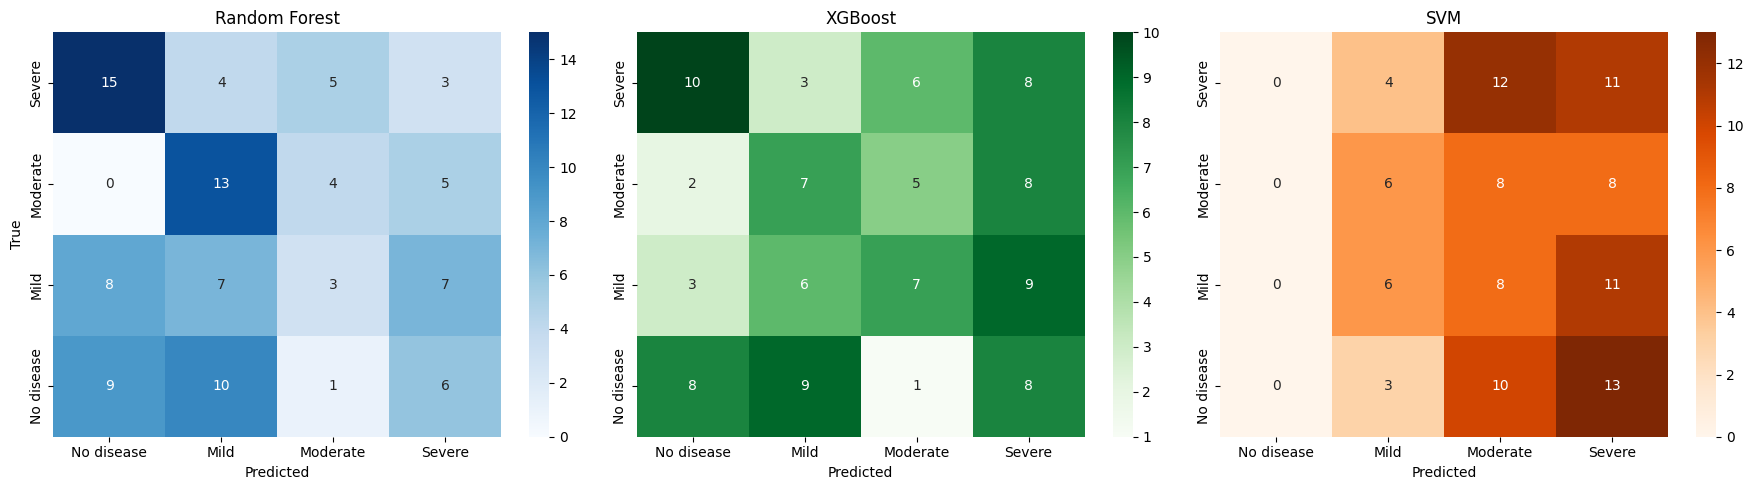

In [73]:
labels = ["No disease", "Mild", "Moderate", "Severe"]

# Confusion matrix
cm_rf = pd.DataFrame(confusion_matrix(y_test, y_pred_rf), index=labels, columns=labels)
cm_xgb = pd.DataFrame(confusion_matrix(y_test, y_pred_xgb), index=labels, columns=labels)
cm_svm = pd.DataFrame(confusion_matrix(y_test, y_pred_svm), index=labels, columns=labels)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Random Forest")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")
axes[0].invert_yaxis() 

sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("XGBoost")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("")
axes[1].invert_yaxis() 

sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Oranges", ax=axes[2])
axes[2].set_title("SVM")
axes[2].set_xlabel("Predicted")
axes[2].set_ylabel("")
axes[2].invert_yaxis() 

plt.tight_layout()
plt.show()

Random Forest and XGBoost produced relatively balanced predictions but often confused Mild, Moderate, and Severe cases.
XGBoost performed slightly better, with more accurate predictions across classes.
SVM overpredicted the Severe class and failed to detect the Moderate class entirely.

Overall, all models struggled to distinguish between disease levels, confirming the limited predictive power of the available features.

 ***3. Interpretation of the models***

All tested models showed poor performance, indicating that the current feature set lacks the specificity needed to differentiate between disease levels.
This suggests that additional inputs — such as pathogen-specific indicators, crop genotype, or sensor-based stress measurements — may be essential to improve classification accuracy.

#### **Objective 3 - 🌾 Crop Yield Forecast**

The same thing is made in this part of the notebook.<br>The objective is to <u>forecast crop yield</u> (*yield_kg_per_hectare*) from environmental conditions, soil variables and operating practices (the same of Objective 2).

Two models are tested:
- Linear regression
- Random forest

 ***1. Preprocessing***


The features are the same of Objective 2.

In [47]:
# Target variable
y2 = df['yield_kg_per_hectare']

In [ ]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.2, random_state=42)

((400, 14), (100, 14), (400,), (100,))

 ***2. Models construction***

##### Linear Regression

In [50]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

In [72]:
def evaluate_model(y_true, y_pred):
    return {
        "MAE": round(mean_absolute_error(y_true, y_pred), 2),
        "RMSE": float(round(np.sqrt(mean_squared_error(y_true, y_pred)), 2)),
        "R²": round(r2_score(y_true, y_pred), 3)
    }

lr_metrics = evaluate_model(y_test, y_pred_lr)
lr_metrics

{'MAE': 1065.56, 'RMSE': 1200.9, 'R²': -0.044}

##### Random forest

In [51]:
rf_model_reg = RandomForestRegressor(random_state=42)
rf_model_reg.fit(X_train, y_train)
y_pred_rf = rf_model_reg.predict(X_test)

In [73]:
rf_metrics = evaluate_model(y_test, y_pred_rf)
rf_metrics

{'MAE': 1059.98, 'RMSE': 1208.12, 'R²': -0.057}

Feature importance

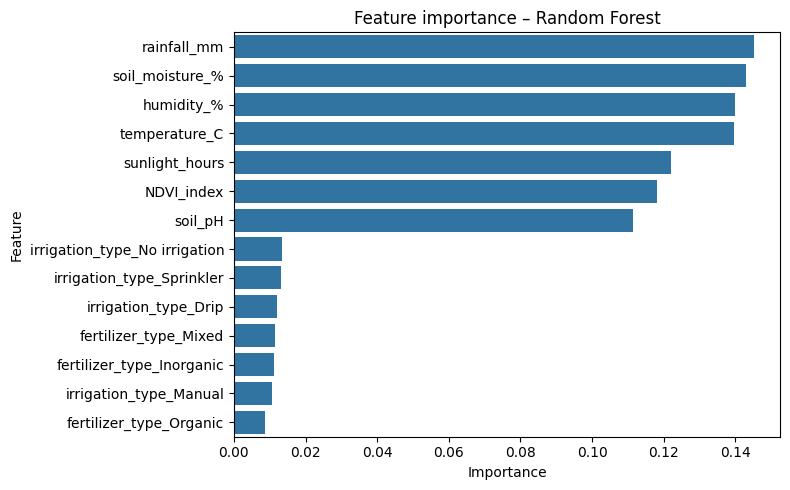

In [ ]:
importances = rf_model_reg.feature_importances_
feature_names = X.columns
feat_imp = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feat_imp = feat_imp.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x="Importance", y="Feature", data=feat_imp)
plt.title("Feature importance – Random Forest")
plt.tight_layout()
plt.show()

I extracted feature importances from the trained Random Forest model.

- Environmental variables like rainfall, soil moisture, humidity, temperature and sunlight hours emerged as the most influential features, suggesting that crop yield is primarily driven by meteorological conditions.

- NDVI index and soil pH also contributed meaningfully to the model.

- Operational factors like irrigation type and fertilizer type showed comparatively lower importance, possibly due to limited variability or indirect effects.
<br>

This analysis provides useful insights into which variables the model prioritizes, even though the overall predictive performance remained limited — likely due to the small dataset size and the lack of other agronomic or contextual variables.

##### Comparison between the 2 models

| Model                 | MAE (kg/ha) | RMSE (kg/ha) | R²     |
| --------------------- | ----------- | ------------ | ------ |
| **Linear Regression** | 1065.56     | 1200.90      | -0.044 |
| **Random Forest**     | 1059.98     | 1208.12      | -0.057 |


Both models showed poor predictive performance, with R² values below zero, indicating that neither was able to outperform a simple baseline prediction using the mean yield.
In this case, <u>Linear Regression slightly outperformed Random Forest</u> in terms of R², although the difference is marginal and not practically significant.

Moreover, the RMSE values — around 1200 kg/ha — are relatively high, suggesting that the models make large absolute errors in predicting crop yield.

This further confirms that the selected features alone are insufficient to capture the complexity behind yield variation in this dataset.

Real vs Predict

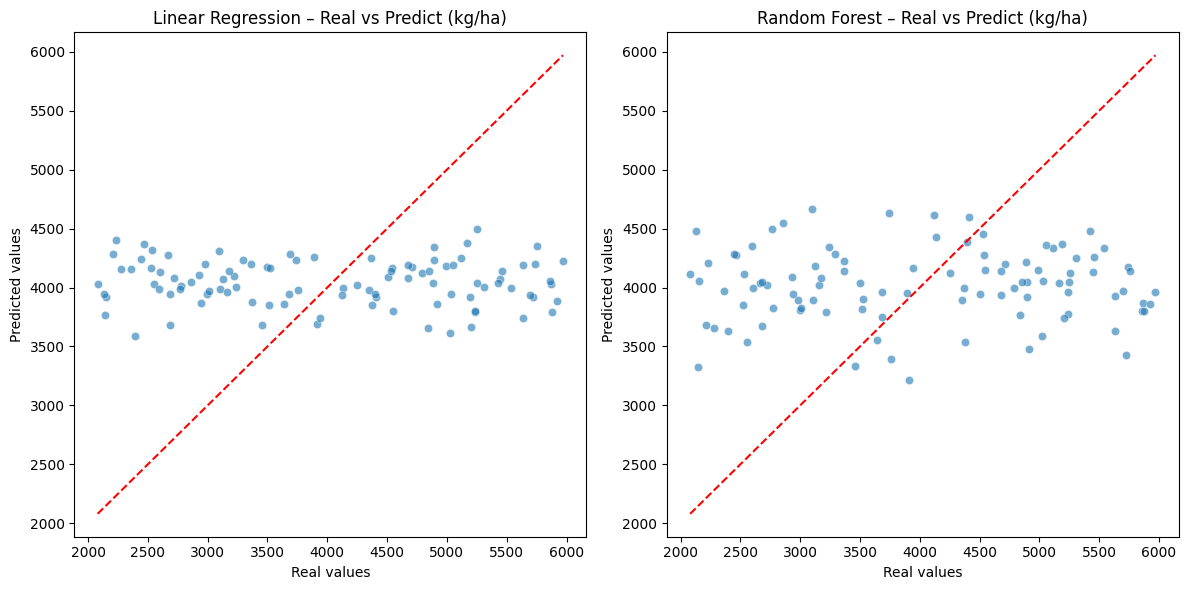

In [ ]:
plt.figure(figsize=(12, 6))

# Linear Regression
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Real values")
plt.ylabel("Predicted values")
plt.title("Linear Regression – Real vs Predict (kg/ha)")

# Random Forest
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Real values")
plt.ylabel("Predicted values")
plt.title("Random Forest – Real vs Predict (kg/ha)")

plt.tight_layout()
plt.show()

For both  models this pattern confirms the low predictive performance observed in the evaluation metrics and suggests that the models lack the ability to generalize yield variations based on the available features.

 ***3. Interpretation of the models***

The prediction of crop yield using only environmental and operational data from this dataset proved to be challenging. The low performance highlights the need for more granular or domain-specific variables, such as crop variety, real-time stress indicators, or soil fertility indices.

######################################################################

## 4. 🧾 Summary and Next Steps

This project explored a smart farming dataset to analyze and predict two key aspects of crop performance: yield and disease severity. The analysis combined exploratory data visualization, supervised machine learning models, and geospatial storytelling.

✅ Summary of findings:<br>
<br>
- Environmental variables (e.g., rainfall, temperature, humidity) showed the strongest influence on crop yield, while operational features like irrigation and fertilizer type had limited predictive power.

- Regression models (Random Forest, Linear Regression) struggled to predict yield accurately, with R² scores below zero — indicating that more granular data may be needed.

- Classification models (Random Forest, XGBoost, SVM) also showed poor performance in detecting crop disease levels, with strong class imbalance and overlapping predictions.

- Geographic visualizations using NDVI and farm location added interpretability, revealing potential spatial patterns in crop health.

🚀 Next steps:<br>
<br>

- Incorporate **more detailed and agronomic features**, such as crop variety, genotype, sensor-based stress data, and disease-specific indicators.

- Consider applying **class balancing techniques** (e.g., `SMOTE`) and **model calibration** to address class imbalance and improve the robustness of disease classification models.

- Explore **SHAP values** or **feature interaction analysis** (especially for `Random Forest` and `XGBoost`) to better interpret model decisions and enhance transparency.

- Implement **cross-validation** to obtain more reliable model evaluations and reduce dependence on a single train/test split.


---
---

## Useful links
https://www.agricolus.com/en/vegetation-indices-ndvi-ndmi/